# Assignment 4 — SEMMA Case Study (Adult Income Classification)

Dataset: [`scikit-learn/adult-census-income`](https://huggingface.co/datasets/scikit-learn/adult-census-income)

Goal: Predict income (<=50K vs >50K) using SEMMA: Sample, Explore, Modify, Model, Assess.

Environment: Python 3.11 (`.venv`), scikit-learn, imbalanced-learn, pandas, seaborn, SHAP.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from datasets import load_dataset
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap

sns.set_theme(style="whitegrid")
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)
RNG = 42
pd.set_option("display.max_columns", 50)

## Sample
- Load dataset from Hugging Face
- Stratified split train/valid/test

In [2]:
ds = load_dataset("scikit-learn/adult-census-income", split="train")
df = ds.to_pandas()
df.shape, df["income"].value_counts(normalize=True)

((32561, 15),
 income
 <=50K    0.75919
 >50K     0.24081
 Name: proportion, dtype: float64)

In [3]:
target = "income"
X = df.drop(columns=[target])
y = df[target].apply(lambda v: 1 if v.strip() == ">50K" else 0)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RNG
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=RNG
)
(X_train.shape, X_valid.shape, X_test.shape)

((20838, 14), (5210, 14), (6513, 14))

## Explore
- Missingness, target balance
- Univariate distributions (numeric)
- Categorical frequency
- Correlations (numeric) and target relationship

In [4]:
missing = df.isna().sum().sort_values(ascending=False)
missing.head(10)

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
dtype: int64

PosixPath('figures/univar_numeric.png')

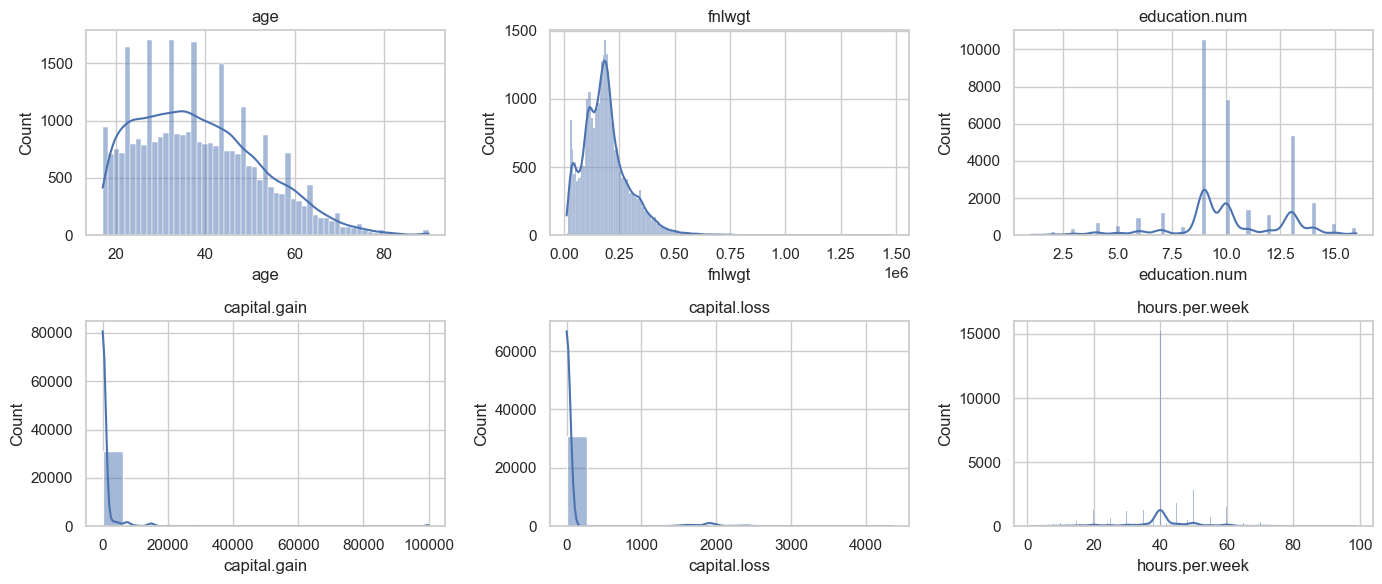

In [5]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "string"]).columns.tolist()

fig, axes = plt.subplots(2, len(numeric_cols)//2, figsize=(14, 6))
axes = axes.flatten()
for ax, col in zip(axes, numeric_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
univar_num_fig = FIG_DIR / "univar_numeric.png"
plt.savefig(univar_num_fig)
univar_num_fig

PosixPath('figures/target_balance.png')

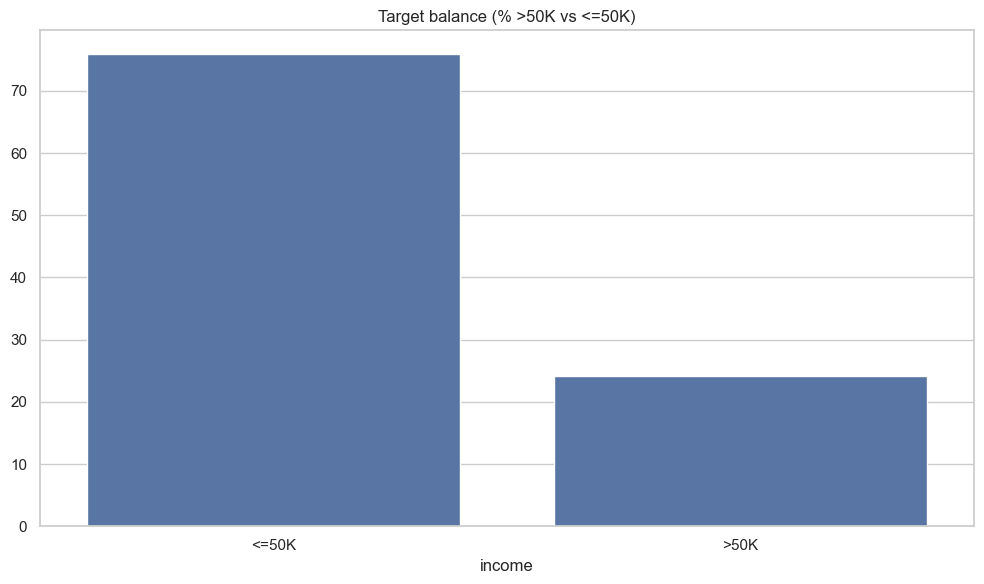

In [6]:
plt.figure(figsize=(10,6))
freq = df[target].value_counts(normalize=True) * 100
sns.barplot(x=freq.index, y=freq.values)
plt.title("Target balance (% >50K vs <=50K)")
plt.tight_layout()
balance_fig = FIG_DIR / "target_balance.png"
plt.savefig(balance_fig)
balance_fig

PosixPath('figures/corr_top_numeric.png')

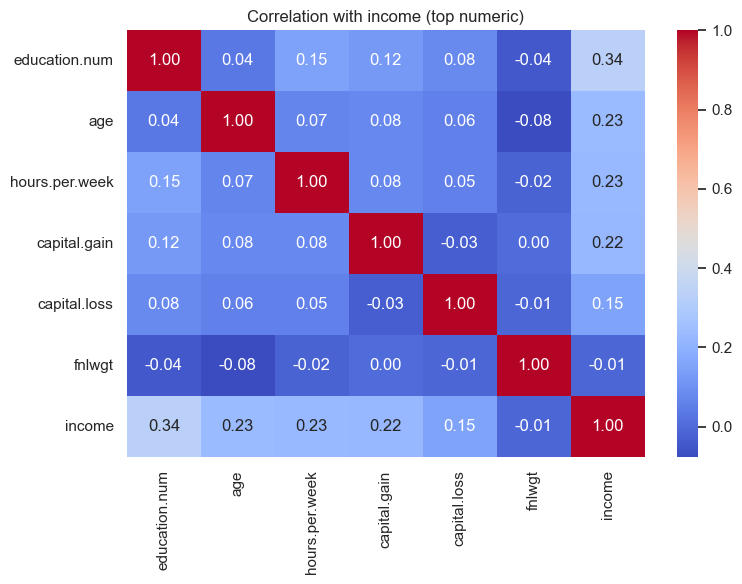

In [7]:
corr = df[numeric_cols + [target]].assign(income=y).corr()["income"].drop("income")
top_corr = corr.abs().sort_values(ascending=False).head(10).index
plt.figure(figsize=(8,6))
sns.heatmap(df[list(top_corr) + [target]].assign(income=y).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation with income (top numeric)")
plt.tight_layout()
corr_fig = FIG_DIR / "corr_top_numeric.png"
plt.savefig(corr_fig)
corr_fig

## Modify
- Impute + one-hot; scale numerics for linear models
- Compare class_weight vs SMOTE for imbalance
- Simple feature tweaks: bin age, combine rare categories if needed (skipped here for brevity)

In [8]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols),
])

def evaluate_clf(pipe, Xtr, ytr, Xval, yval, name: str):
    pipe.fit(Xtr, ytr)
    proba = pipe.predict_proba(Xval)[:, 1]
    preds = (proba >= 0.5).astype(int)
    roc = roc_auc_score(yval, proba)
    pr = average_precision_score(yval, proba)
    return {"name": name, "roc_auc": roc, "avg_precision": pr, "pipeline": pipe}

results = []
results.append(evaluate_clf(
    Pipeline([
        ("prep", preprocessor),
        ("model", DummyClassifier(strategy="most_frequent"))
    ]),
    X_train, y_train, X_valid, y_valid, "Dummy")
)

results.append(evaluate_clf(
    Pipeline([
        ("prep", preprocessor),
        ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]),
    X_train, y_train, X_valid, y_valid, "LogReg (balanced)")
)

results.append(evaluate_clf(
    ImbPipeline([
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=RNG)),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    X_train, y_train, X_valid, y_valid, "LogReg + SMOTE")
)

results.append(evaluate_clf(
    Pipeline([
        ("prep", preprocessor),
        ("model", GradientBoostingClassifier(random_state=RNG))
    ]),
    X_train, y_train, X_valid, y_valid, "GradientBoosting")
)

pd.DataFrame([{k: v for k, v in r.items() if k != "pipeline"} for r in results])

,name,roc_auc,avg_precision
0,Dummy,0.500000,0.240883
1,LogReg (balanced),0.897559,0.742436
2,LogReg + SMOTE,0.896891,0.742402
3,GradientBoosting,0.913904,0.796013


In [9]:
# Pick best by ROC-AUC
best = sorted(results, key=lambda d: d["roc_auc"], reverse=True)[0]
best_name = best["name"]
best_pipe = best["pipeline"]
best_name

'GradientBoosting'

In [10]:
# Hyperparameter tuning on GradientBoosting
param_dist = {
    "model__n_estimators": [150, 200, 300],
    "model__learning_rate": [0.05, 0.075, 0.1],
    "model__max_depth": [2, 3, 4],
}
search = RandomizedSearchCV(
    Pipeline([
        ("prep", preprocessor),
        ("model", GradientBoostingClassifier(random_state=RNG))
    ]),
    param_distributions=param_dist,
    n_iter=8,
    cv=3,
    scoring="roc_auc",
    random_state=RNG,
    n_jobs=-1,
)
search.fit(X_train, y_train)
{'best_params': search.best_params_, 'best_cv_roc_auc': search.best_score_}

{'best_params': {'model__n_estimators': 300,
  'model__max_depth': 4,
  'model__learning_rate': 0.075},
 'best_cv_roc_auc': 0.9293106767207252}

In [11]:
# Refit tuned model on train+valid, evaluate on test
tuned_pipe = search.best_estimator_
tuned_pipe.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

proba_test = tuned_pipe.predict_proba(X_test)[:,1]
preds_test = (proba_test >= 0.5).astype(int)
roc_test = roc_auc_score(y_test, proba_test)
pr_test = average_precision_score(y_test, proba_test)
cm = confusion_matrix(y_test, preds_test)

report = classification_report(y_test, preds_test, target_names=["<=50K", ">50K"], output_dict=True)
roc_test, pr_test, cm, report

(0.9233390638864242,
 0.8217675066121778,
 array([[4654,  291],
        [ 564, 1004]]),
 {'<=50K': {'precision': 0.8919126101954772,
   'recall': 0.9411526794742163,
   'f1-score': 0.9158712978451244,
   'support': 4945.0},
  '>50K': {'precision': 0.7752895752895753,
   'recall': 0.6403061224489796,
   'f1-score': 0.7013622074746769,
   'support': 1568.0},
  'accuracy': 0.8687240902809765,
  'macro avg': {'precision': 0.8336010927425263,
   'recall': 0.7907294009615979,
   'f1-score': 0.8086167526599006,
   'support': 6513.0},
  'weighted avg': {'precision': 0.8638356995962979,
   'recall': 0.8687240902809765,
   'f1-score': 0.8642283907821946,
   'support': 6513.0}})

PosixPath('figures/roc_pr_curves.png')

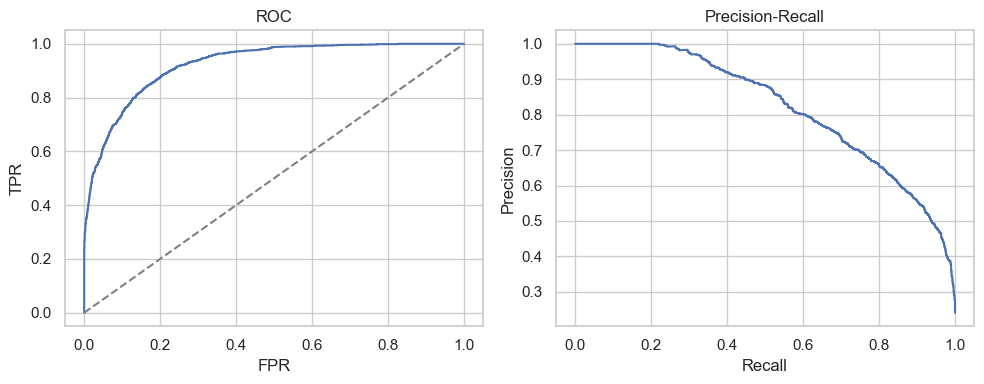

In [12]:
# ROC and PR curves
fpr, tpr, _ = roc_curve(y_test, proba_test)
prec, rec, _ = precision_recall_curve(y_test, proba_test)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(fpr, tpr, label=f"ROC-AUC={roc_test:.3f}")
ax[0].plot([0,1],[0,1],'--', color='gray')
ax[0].set_title("ROC")
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")

ax[1].plot(rec, prec, label=f"PR-AUC={pr_test:.3f}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.tight_layout()
curves_fig = FIG_DIR / "roc_pr_curves.png"
plt.savefig(curves_fig)
curves_fig

PosixPath('figures/confusion_matrix.png')

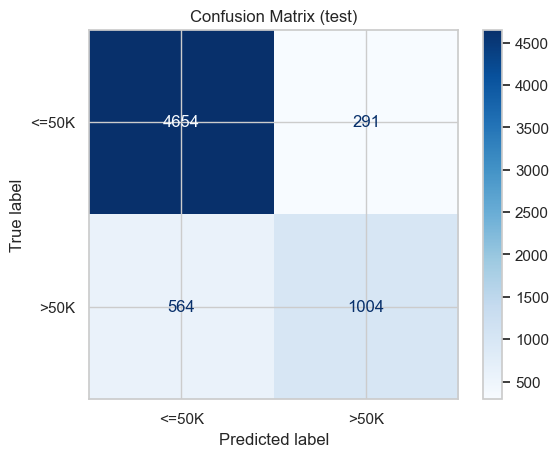

In [13]:
# Confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (test)")
cm_fig = FIG_DIR / "confusion_matrix.png"
plt.savefig(cm_fig)
cm_fig

PosixPath('figures/shap_beeswarm.png')

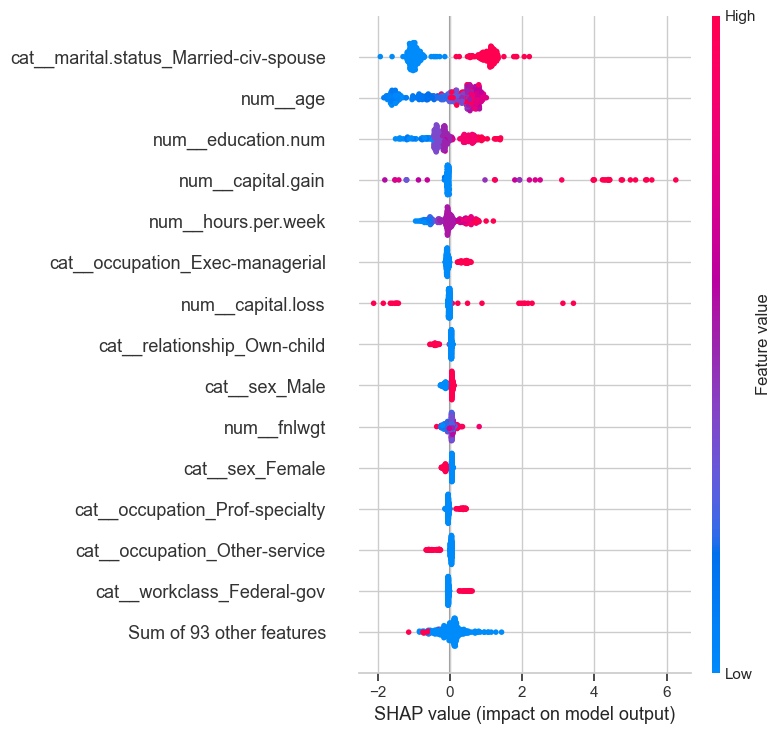

In [14]:
# SHAP summary (on a sample for speed)
X_sample = X_test.sample(n=min(400, len(X_test)), random_state=RNG)
X_proc = tuned_pipe.named_steps["prep"].transform(X_sample)
if hasattr(X_proc, "toarray"):
    X_proc = X_proc.toarray()
feature_names = tuned_pipe.named_steps["prep"].get_feature_names_out()
explainer = shap.Explainer(tuned_pipe.named_steps["model"], X_proc, feature_names=feature_names)
shap_values = explainer(X_proc)
shap.plots.beeswarm(shap_values, max_display=15, show=False)
plt.tight_layout()
shap_fig = FIG_DIR / "shap_beeswarm.png"
plt.savefig(shap_fig, bbox_inches="tight")
shap_fig

In [15]:
# Slice metrics (by sex and marital.status)
slice_cols = ["sex", "marital.status"]
slice_metrics = []
df_test = X_test.copy()
df_test["y"] = y_test.values
df_test["proba"] = proba_test
df_test["pred"] = preds_test
for col in slice_cols:
    for level, grp in df_test.groupby(col):
        roc = roc_auc_score(grp["y"], grp["proba"]) if grp["y"].nunique()>1 else np.nan
        pr = average_precision_score(grp["y"], grp["proba"]) if grp["y"].nunique()>1 else np.nan
        slice_metrics.append({"slice": f"{col}={level}", "roc_auc": roc, "avg_precision": pr, "n": len(grp)})
pd.DataFrame(slice_metrics).sort_values("roc_auc", ascending=False).head(10)

,slice,roc_auc,avg_precision,n
0,sex=Female,0.945678,0.791493,2153
6,marital.status=Never-married,0.937663,0.647689,2133
7,marital.status=Separated,0.921134,0.603545,211
5,marital.status=Married-spouse-absent,0.920548,0.779911,83
1,sex=Male,0.902186,0.825996,4360
8,marital.status=Widowed,0.887468,0.707855,201
2,marital.status=Divorced,0.876811,0.677993,880
4,marital.status=Married-civ-spouse,0.851730,0.841366,3001
3,marital.status=Married-AF-spouse,0.333333,0.333333,4


## Assess (summary)
- Best model: tuned GradientBoostingClassifier with one-hot + scaling, evaluated on test.
- Report: see classification_report, ROC/PR curves, confusion matrix, slices, and SHAP.
- Deployment: bundle preprocess + model, monitor slice metrics and calibration.